In [1]:
import pandas as pd

In [2]:
superstore_df = pd.read_csv("./data/Sample - Superstore.csv", encoding='windows-1252')

In [3]:
superstore_df.head(2)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.96,2,0.0,41.9136
1,2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.94,3,0.0,219.5820


In [4]:
superstore_df['Order Date'] = pd.to_datetime(superstore_df['Order Date'])
superstore_df['Ship Date'] = pd.to_datetime(superstore_df['Ship Date'])

In [5]:
superstore_df.isnull().sum()

Row ID           0
Order ID         0
Order Date       0
Ship Date        0
Ship Mode        0
Customer ID      0
Customer Name    0
Segment          0
Country          0
City             0
State            0
Postal Code      0
Region           0
Product ID       0
Category         0
Sub-Category     0
Product Name     0
Sales            0
Quantity         0
Discount         0
Profit           0
dtype: int64

In [6]:
superstore_df.describe()

,Row ID,Order Date,Ship Date,Postal Code,Sales,Quantity,Discount,Profit
count,9994.000000,9994,9994,9994.000000,9994.000000,9994.000000,9994.000000,9994.000000
mean,4997.500000,2016-04-30 00:07:12.259355648,2016-05-03 23:06:58.571142912,55190.379428,229.858001,3.789574,0.156203,28.656896
min,1.000000,2014-01-03 00:00:00,2014-01-07 00:00:00,1040.000000,0.444000,1.000000,0.000000,-6599.978000
25%,2499.250000,2015-05-23 00:00:00,2015-05-27 00:00:00,23223.000000,17.280000,2.000000,0.000000,1.728750
50%,4997.500000,2016-06-26 00:00:00,2016-06-29 00:00:00,56430.500000,54.490000,3.000000,0.200000,8.666500
75%,7495.750000,2017-05-14 00:00:00,2017-05-18 00:00:00,90008.000000,209.940000,5.000000,0.200000,29.364000
max,9994.000000,2017-12-30 00:00:00,2018-01-05 00:00:00,99301.000000,22638.480000,14.000000,0.800000,8399.976000
std,2885.163629,NaN,NaN,32063.693350,623.245101,2.225110,0.206452,234.260108


In [7]:
superstore_df.skew(numeric_only=True)

Row ID          0.000000
Postal Code    -0.128526
Sales          12.972752
Quantity        1.278545
Discount        1.684295
Profit          7.561432
dtype: float64

## RFM

[Reference for RFM](https://www.datacamp.com/tutorial/introduction-customer-segmentation-python)

Since the data is from '2014-01-03' to '2017-12-30', when we calcualte the recency column we can't use today's date as it is too far so we will use TODAY as 1st Jan 2018

In [8]:
#setting today's date as a variable as it will keep changing

TODAY = pd.to_datetime('2018-01-01')

In [9]:
rfm = superstore_df.groupby(['Customer ID']).agg({'Order ID':'count',
                                            'Sales':'sum',
                                            'Order Date': lambda x: (TODAY-x.max()).days}).reset_index().rename(
                                                columns={'Order ID':'frequency',
                                                         'Sales':'monetary',
                                                         'Order Date':'recency'})

rfm.head()

,Customer ID,frequency,monetary,recency
0,AA-10315,11,5563.560,186
1,AA-10375,15,1056.390,21
2,AA-10480,12,1790.512,261
3,AA-10645,18,5086.935,57
4,AB-10015,6,886.156,417


Note on pd.qcut: https://pbpython.com/pandas-qcut-cut.html

- The simplest use of qcut is to define the number of quantiles and let pandas figure out how to divide up the data. So if we declare q as 4, we tell pandas to create 4 equal sized groupings of the data. You'll notice that because we asked for quantiles with q=4 the bins match the percentiles from the describe function.

- One of the challenges with this approach is that the bin labels are not very easy to explain to an end user. For instance, if we wanted to divide our customers into 5 groups (aka quintiles) like an airline frequent flier approach, we can explicitly label the bins to make them easier to interpret. That's where the label parameter is useful.

In [10]:
rfm['recency_quantile'] = pd.qcut(rfm["recency"],q=4,labels=[1,2,3,4])
rfm['frequency_quantile'] = pd.qcut(rfm["frequency"],q=4,labels=[4,3,2,1])
rfm['monetary_quantile'] = pd.qcut(rfm["monetary"],q=4,labels=[4,3,2,1])

rfm.head()

,Customer ID,frequency,monetary,recency,recency_quantile,frequency_quantile,monetary_quantile
0,AA-10315,11,5563.560,186,4,3,1
1,AA-10375,15,1056.390,21,1,2,4
2,AA-10480,12,1790.512,261,4,3,3
3,AA-10645,18,5086.935,57,2,1,1
4,AB-10015,6,886.156,417,4,4,4


Note: Difference between str(df['col]) vs df['col].astype(str) (https://stackoverflow.com/questions/30095172/difference-between-str-and-astypestr)

- str(df['col']) will convert the contents of the entire column in to single string. It will end up with a very big string. 
- You should use `.astype(str)` if you want to convert your entire column to type string

Note: Bitwise vs Logical operators 

- Logical operators (`and` and `or`): are used to combine Boolean expressions, and they operate on whole expressions rather than element-wise. They work by evaluating the truth value of entire expressions, not the individual elements of an array or pandas Series.

- Bitwise operators (`&` and `|`): When used with pandas Series (or NumPy arrays), these operators perform element-wise operations. This means they compare each element of the series individually. Even though these operators are called "bitwise," when applied to Boolean arrays (like those in pandas), they act as element-wise logical operators.

In [11]:
rfm['rfm_rank'] = rfm['recency_quantile'].astype(str) + rfm['frequency_quantile'].astype(str) + rfm['monetary_quantile'].astype(str)

rfm.head()

,Customer ID,frequency,monetary,recency,recency_quantile,frequency_quantile,monetary_quantile,rfm_rank
0,AA-10315,11,5563.560,186,4,3,1,431
1,AA-10375,15,1056.390,21,1,2,4,124
2,AA-10480,12,1790.512,261,4,3,3,433
3,AA-10645,18,5086.935,57,2,1,1,211
4,AB-10015,6,886.156,417,4,4,4,444


In [12]:
def customer_label_function(rfm):
    if rfm['rfm_rank']=='111':
        return "champions"
    elif (rfm['frequency_quantile']==1) & (rfm['recency_quantile']!=4):
        return "loyal customers"
    elif (rfm['monetary_quantile']==1) & (rfm['recency_quantile']!=4):
        return "big spenders"
    elif (rfm['recency_quantile']==1) & (rfm['frequency_quantile']!=4):
        return "recent users"
    elif rfm['rfm_rank']=='444':
       return  "lost"
    else:
       return  "other"

In [13]:
rfm['customer_label'] = rfm.apply(customer_label_function,axis=1)

In [14]:
rfm['customer_label'].value_counts()

customer_label
other              410
loyal customers    134
big spenders        86
recent users        76
lost                58
champions           29
Name: count, dtype: int64

In [15]:
rfm.head()

,Customer ID,frequency,monetary,recency,recency_quantile,frequency_quantile,monetary_quantile,rfm_rank,customer_label
0,AA-10315,11,5563.560,186,4,3,1,431,other
1,AA-10375,15,1056.390,21,1,2,4,124,recent users
2,AA-10480,12,1790.512,261,4,3,3,433,other
3,AA-10645,18,5086.935,57,2,1,1,211,loyal customers
4,AB-10015,6,886.156,417,4,4,4,444,lost


In [16]:
len(rfm)

793

## Customer Segmentation of Loyal Customers

### Feature Engineering 

In [17]:
loyal_customers = rfm[rfm['customer_label']=='loyal customers']

In [18]:
loyal_customers.head(2)

,Customer ID,frequency,monetary,recency,recency_quantile,frequency_quantile,monetary_quantile,rfm_rank,customer_label
3,AA-10645,18,5086.935,57,2,1,1,211,loyal customers
5,AB-10060,18,7755.620,56,2,1,1,211,loyal customers


In [19]:
loyal_customer_sales = loyal_customers.merge(superstore_df,how='inner',on='Customer ID')

In [20]:
loyal_customer_sales.columns

Index(['Customer ID', 'frequency', 'monetary', 'recency', 'recency_quantile',
       'frequency_quantile', 'monetary_quantile', 'rfm_rank', 'customer_label',
       'Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code',
       'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name',
       'Sales', 'Quantity', 'Discount', 'Profit'],
      dtype='object')

In [21]:
loyal_customer_sales[loyal_customer_sales['Row ID'].duplicated()]

,Customer ID,frequency,monetary,recency,recency_quantile,frequency_quantile,monetary_quantile,rfm_rank,customer_label,Row ID,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit


In [22]:
loyal_customer_sales.head()

,Customer ID,frequency,monetary,recency,recency_quantile,frequency_quantile,monetary_quantile,rfm_rank,customer_label,Row ID,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,AA-10645,18,5086.935,57,2,1,1,211,loyal customers,4021,...,19013,East,FUR-CH-10004698,Furniture,Chairs,"Padded Folding Chairs, Black, 4/Carton",170.058,3,0.3,-4.8588
1,AA-10645,18,5086.935,57,2,1,1,211,loyal customers,4022,...,19013,East,TEC-PH-10004093,Technology,Phones,Panasonic Kx-TS550,82.782,3,0.4,-15.1767
2,AA-10645,18,5086.935,57,2,1,1,211,loyal customers,4023,...,19013,East,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",853.930,5,0.3,0.0000
3,AA-10645,18,5086.935,57,2,1,1,211,loyal customers,4452,...,94109,West,FUR-FU-10000221,Furniture,Furnishings,"Master Caster Door Stop, Brown",25.400,5,0.0,8.6360
4,AA-10645,18,5086.935,57,2,1,1,211,loyal customers,4453,...,94109,West,OFF-EN-10003567,Office Supplies,Envelopes,"Inter-Office Recycled Envelopes, Brown Kraft, ...",43.960,2,0.0,20.6612


In [23]:
loyal_customer_sales['Segment'].value_counts()

Segment
Consumer       1364
Corporate       969
Home Office     508
Name: count, dtype: int64

In [24]:
loyal_customer_sales['Category'].value_counts()

Category
Office Supplies    1721
Furniture           600
Technology          520
Name: count, dtype: int64

In [25]:
loyal_customer_sales['Sub-Category'].value_counts()

Sub-Category
Binders        440
Paper          386
Furnishings    282
Phones         241
Storage        238
Art            226
Accessories    226
Chairs         177
Appliances     119
Labels         106
Envelopes       86
Tables          77
Fasteners       67
Bookcases       64
Supplies        53
Machines        38
Copiers         15
Name: count, dtype: int64

In [26]:
loyal_customer_sales['Region'].value_counts()

Region
West       859
East       837
Central    691
South      454
Name: count, dtype: int64

In [27]:
loyal_customer_sales['Discount'].value_counts()

Discount
0.00    1339
0.20    1019
0.70     148
0.80      85
0.30      81
0.40      54
0.60      45
0.10      29
0.15      19
0.50      14
0.32       5
0.45       3
Name: count, dtype: int64

In [28]:
loyal_customer_sales['Ship Mode'].value_counts()

Ship Mode
Standard Class    1694
Second Class       550
First Class        428
Same Day           169
Name: count, dtype: int64

In [29]:
loyal_customer_sales.sort_values(by=['Customer ID','Order Date'],inplace=True)
loyal_customer_sales['Previous Order Date'] = loyal_customer_sales.groupby(['Customer ID']).shift()['Order Date']
loyal_customer_sales['Time b/w previous purchase'] = (loyal_customer_sales['Order Date']-loyal_customer_sales['Previous Order Date']).dt.days

In [30]:
loyal_customer_sales.head()

,Customer ID,frequency,monetary,recency,recency_quantile,frequency_quantile,monetary_quantile,rfm_rank,customer_label,Row ID,...,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Previous Order Date,Time b/w previous purchase
0,AA-10645,18,5086.935,57,2,1,1,211,loyal customers,4021,...,FUR-CH-10004698,Furniture,Chairs,"Padded Folding Chairs, Black, 4/Carton",170.058,3,0.3,-4.8588,NaT,NaN
1,AA-10645,18,5086.935,57,2,1,1,211,loyal customers,4022,...,TEC-PH-10004093,Technology,Phones,Panasonic Kx-TS550,82.782,3,0.4,-15.1767,2014-06-22,0.0
2,AA-10645,18,5086.935,57,2,1,1,211,loyal customers,4023,...,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",853.930,5,0.3,0.0000,2014-06-22,0.0
12,AA-10645,18,5086.935,57,2,1,1,211,loyal customers,8004,...,TEC-PH-10004434,Technology,Phones,Cisco IP Phone 7961G VoIP phone - Dark gray,271.900,2,0.0,78.8510,2014-06-22,162.0
13,AA-10645,18,5086.935,57,2,1,1,211,loyal customers,8005,...,FUR-FU-10003878,Furniture,Furnishings,"Linden 10"" Round Wall Clock, Black",45.840,3,0.0,15.5856,2014-12-01,0.0


In [31]:
loyal_customer_sales[loyal_customer_sales['Time b/w previous purchase']<0]

,Customer ID,frequency,monetary,recency,recency_quantile,frequency_quantile,monetary_quantile,rfm_rank,customer_label,Row ID,...,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Previous Order Date,Time b/w previous purchase


In [32]:
loyal_customer_sales['Country'].value_counts()

Country
United States    2841
Name: count, dtype: int64

In [33]:
# get most recent city, state and region

grouped_location_data = loyal_customer_sales.sort_values(by=['Customer ID','Order Date'],ascending=[True,
                                                                            False]).groupby(['Customer ID']).first()[['City',
                                                                                                                      'State',
                                                                                                                      'Region']].reset_index()

grouped_location_data.rename(columns={"City":'recent_city',"State":'recent_state',"Region":'recent_region'},inplace=True)
grouped_location_data.head(2)

,Customer ID,recent_city,recent_state,recent_region
0,AA-10645,San Diego,California,West
1,AB-10060,Seattle,Washington,West


In [34]:
grouped_category_data = loyal_customer_sales.groupby(['Customer ID','Category']).count()['Order ID'].reset_index()

grouped_category_data.head(2)

,Customer ID,Category,Order ID
0,AA-10645,Furniture,8
1,AA-10645,Office Supplies,8


In [35]:
pivoted_category_data = grouped_category_data.pivot(index='Customer ID',
                                                    columns='Category',values='Order ID').reset_index().rename(columns = {'Furniture':'furniture_count',
                                                                                                                'Office Supplies':'office_supplies_count',
                                                                                                                'Technology':'tech_count'})
pivoted_category_data.fillna(0,inplace=True)
pivoted_category_data.head(2)

Category,Customer ID,furniture_count,office_supplies_count,tech_count
0,AA-10645,8.0,8.0,2.0
1,AB-10060,3.0,12.0,3.0


In [36]:
grouped_shipping_data = loyal_customer_sales.groupby(['Customer ID','Ship Mode']).count()['Order ID'].reset_index()

pivoted_shipping_data = grouped_shipping_data.pivot(index='Customer ID',
                                                    columns='Ship Mode',values='Order ID').reset_index().rename(columns = {'Standard Class':'standard_class_count',
                                                                                                                'Second Class':'second_class_count',
                                                                                                                'First Class':'first_class_count',
                                                                                                                'Same Day':'same_class_count'})

pivoted_shipping_data.fillna(0,inplace=True)
pivoted_shipping_data.head(2)

Ship Mode,Customer ID,first_class_count,same_class_count,second_class_count,standard_class_count
0,AA-10645,7.0,0.0,0.0,11.0
1,AB-10060,8.0,0.0,0.0,10.0


In [37]:
grouped_segment_data = loyal_customer_sales.groupby(['Customer ID','Segment']).count()['Order ID'].reset_index()

pivoted_segment_data = grouped_segment_data.pivot(index='Customer ID',
                                                    columns='Segment',values='Order ID').reset_index().rename(columns = {'Consumer':'consumer_segment_count',
                                                                                                                'Home Office':'home_office_segment_count',
                                                                                                                'Corporate':'corporate_segment_count'})

pivoted_segment_data.fillna(0,inplace=True)
pivoted_segment_data.head(2)

Segment,Customer ID,consumer_segment_count,corporate_segment_count,home_office_segment_count
0,AA-10645,18.0,0.0,0.0
1,AB-10060,0.0,0.0,18.0


In [38]:
grouped_sales_data = loyal_customer_sales.groupby(['Customer ID']).agg({'Sales':'mean','Quantity':'mean',
                                                #    'Segment': lambda x: x.value_counts().index[0],
                                                #    'Ship Mode':lambda x: x.value_counts().index[0],
                                                #    'Category':lambda x: x.value_counts().index[0],
                                                   'Time b/w previous purchase':'mean',
                                                   'Order Date':lambda x: (TODAY-x.min()).days}).reset_index().rename(columns={
                                                       "Sales":'avg_order_value','Quantity':'avg_quantity',
                                                       "Segment":'freq_segment','Ship Mode':'freq_ship_mode',
                                                       'Time b/w previous purchase':'avg_time_b/w_orders',
                                                       'Order Date':'customer_tenure'
                                                   })

grouped_sales_data.head(2)

,Customer ID,avg_order_value,avg_quantity,avg_time_b/w_orders,customer_tenure
0,AA-10645,282.607500,3.555556,72.470588,1289
1,AB-10060,430.867778,3.111111,45.882353,836


In [39]:
# grouped_data = grouped_sales_data.merge(grouped_location_data,on='Customer ID',how='inner')
# grouped_data = grouped_data.merge(pivoted_category_data,on='Customer ID',how='inner')
# grouped_data = grouped_data.merge(pivoted_shipping_data,on='Customer ID',how='inner')
# grouped_data = grouped_data.merge(pivoted_segment_data,on='Customer ID',how='inner')

grouped_data = grouped_sales_data.merge(loyal_customer_sales[['Customer ID','frequency', 'monetary', 'recency', 'recency_quantile',
       'frequency_quantile', 'monetary_quantile', 'rfm_rank']],on='Customer ID',how='inner').drop_duplicates(subset=['Customer ID'])

grouped_data.head()

,Customer ID,avg_order_value,avg_quantity,avg_time_b/w_orders,customer_tenure,frequency,monetary,recency,recency_quantile,frequency_quantile,monetary_quantile,rfm_rank
0,AA-10645,282.607500,3.555556,72.470588,1289,18,5086.935,57,2,1,1,211
18,AB-10060,430.867778,3.111111,45.882353,836,18,7755.620,56,2,1,1,211
36,AB-10105,723.678550,3.650000,56.052632,1108,20,14473.571,43,2,1,1,211
56,AC-10615,140.982556,3.277778,48.882353,839,18,2537.686,8,1,1,2,112
74,AG-10495,112.231190,4.428571,50.650000,1093,21,2356.855,80,3,1,2,312


In [40]:
grouped_data.columns

Index(['Customer ID', 'avg_order_value', 'avg_quantity', 'avg_time_b/w_orders',
       'customer_tenure', 'frequency', 'monetary', 'recency',
       'recency_quantile', 'frequency_quantile', 'monetary_quantile',
       'rfm_rank'],
      dtype='object')

### Clustering

In [41]:
#TODO: 
# 1. convert categorical columns to numeric - done
# 2. Check assumptions of K Means and scale data
# 3. Apply PCA
# 4. Get optimal K using silhoutte method and apply K Means

In [42]:
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [67]:
# clustering_data = grouped_data.drop(columns=['Customer ID','recent_city','recent_state','recent_region'])
clustering_data = grouped_data.drop(columns=['Customer ID','recency_quantile', 'frequency_quantile', 'monetary_quantile',
       'rfm_rank','monetary'])

In [68]:
# vif_data = clustering_data.copy()

# for index in range(len(vif_data.columns)):
#     print(vif_data.columns[index] + ":")
#     print(variance_inflation_factor(vif_data.values, index))


In [69]:
clustering_data.columns

Index(['avg_order_value', 'avg_quantity', 'avg_time_b/w_orders',
       'customer_tenure', 'frequency', 'recency'],
      dtype='object')

In [70]:
clustering_data.dtypes

avg_order_value        float64
avg_quantity           float64
avg_time_b/w_orders    float64
customer_tenure          int64
frequency                int64
recency                  int64
dtype: object

In [71]:
for col in clustering_data.columns:
    clustering_data[col] = clustering_data[col].astype('float64')

clustering_data.dtypes

avg_order_value        float64
avg_quantity           float64
avg_time_b/w_orders    float64
customer_tenure        float64
frequency              float64
recency                float64
dtype: object

In [72]:
clustering_data.isnull().sum()

avg_order_value        0
avg_quantity           0
avg_time_b/w_orders    0
customer_tenure        0
frequency              0
recency                0
dtype: int64

In [73]:
clustering_data.shape

(134, 6)

K Means assumptions:

1. Variables have same mean
2. Variables have same variance
3. Symmetric distribution of variables


In [74]:
clustering_data.skew(numeric_only=True)

avg_order_value        2.257614
avg_quantity           0.493794
avg_time_b/w_orders   -0.125385
customer_tenure       -1.337924
frequency              1.281581
recency                0.803788
dtype: float64

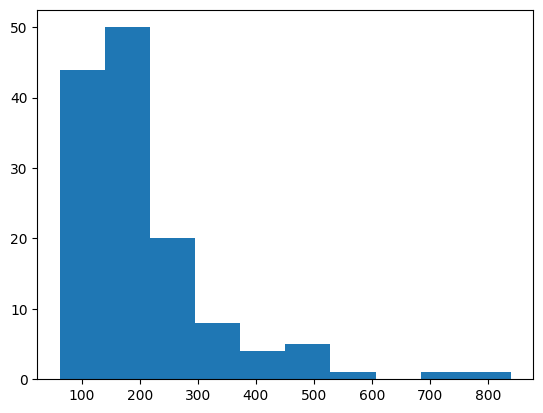

In [75]:
import matplotlib.pyplot as plt

plt.hist(clustering_data['avg_order_value'])
plt.show()

In [76]:
clustering_data.describe()

,avg_order_value,avg_quantity,avg_time_b/w_orders,customer_tenure,frequency,recency
count,134.000000,134.000000,134.000000,134.000000,134.000000,134.000000
mean,202.981804,3.750383,58.309631,1206.865672,21.201493,65.664179
std,124.956772,0.468097,13.515820,184.231458,4.194124,43.951433
min,61.802118,2.764706,26.000000,563.000000,17.000000,2.000000
25%,124.928788,3.411765,48.161899,1140.500000,18.000000,34.250000
50%,164.599216,3.707143,59.280263,1238.500000,20.000000,50.500000
75%,236.080138,4.000000,68.781250,1335.750000,23.000000,98.000000
max,839.852167,5.111111,88.875000,1459.000000,34.000000,182.000000


Need to transform data as the assumptions do not hold

In [77]:
std = StandardScaler()
scaled_data = std.fit_transform(clustering_data)

In [78]:
scaled_data.shape

(134, 6)

Apply PCA to reduce the dimensions

In [79]:
from sklearn.decomposition import PCA

pca= PCA()
pca_clustering_data = pca.fit(scaled_data)

In [80]:
pca.explained_variance_ratio_

array([0.31779732, 0.21926088, 0.19625746, 0.13914516, 0.12528994,
       0.00224924])

Text(0.5, 1.0, 'Cumulative Explained Variance')

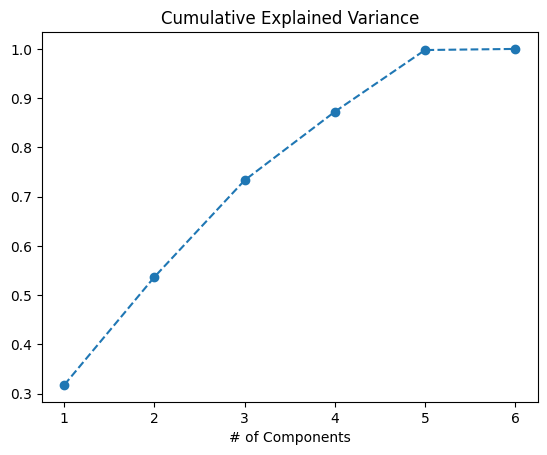

In [81]:
plt.plot(range(1,len(pca.explained_variance_ratio_)+1),pca.explained_variance_ratio_.cumsum(),marker='o',linestyle='--')
plt.title('Explained Variance by Components')
plt.xlabel('# of Components')
plt.title('Cumulative Explained Variance')

The graph shows the amount of variance captured (on the y-axis) depending on the number of components we include (the x-axis). A rule of thumb is to preserve around 80 % of the variance. So, in this instance, we decide to keep 4 components.

In [82]:
pca= PCA(n_components=4)
pca_clustering_data = pca.fit_transform(scaled_data)

In [83]:
pca_clustering_data.shape

(134, 4)

K Means

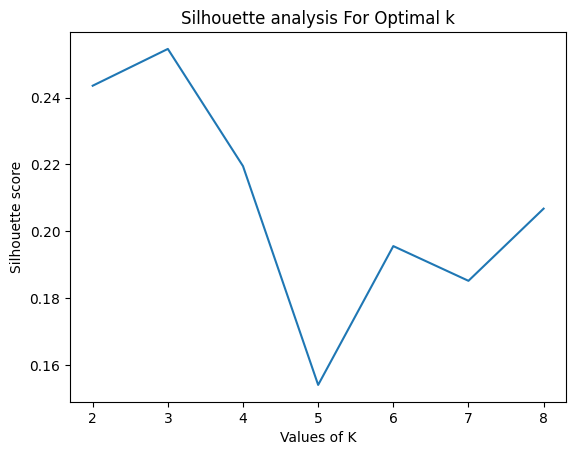

In [84]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
silhouette_avg = []
for num_clusters in range_n_clusters:
    # initialise kmeans
    kmeans = KMeans(n_clusters=num_clusters,init='k-means++',random_state=123)
    kmeans.fit(pca_clustering_data)
    cluster_labels = kmeans.labels_
    # silhouette score
    silhouette_avg.append(silhouette_score(pca_clustering_data, cluster_labels))

plt.plot(range_n_clusters,silhouette_avg)
plt.xlabel('Values of K') 
plt.ylabel('Silhouette score') 
plt.title('Silhouette analysis For Optimal k')
plt.show()

We see that the k means silhouette score is maximized at k = 3. So, we will take 3 clusters.

In [85]:
kmeans = KMeans(n_clusters=3,init='k-means++',random_state=123)
kmeans.fit(pca_clustering_data)
cluster_labels = kmeans.labels_

In [86]:
len(cluster_labels)

134

In [87]:
grouped_data

,Customer ID,avg_order_value,avg_quantity,avg_time_b/w_orders,customer_tenure,frequency,monetary,recency,recency_quantile,frequency_quantile,monetary_quantile,rfm_rank
0,AA-10645,282.607500,3.555556,72.470588,1289,18,5086.935,57,2,1,1,211
18,AB-10060,430.867778,3.111111,45.882353,836,18,7755.620,56,2,1,1,211
36,AB-10105,723.678550,3.650000,56.052632,1108,20,14473.571,43,2,1,1,211
56,AC-10615,140.982556,3.277778,48.882353,839,18,2537.686,8,1,1,2,112
74,AG-10495,112.231190,4.428571,50.650000,1093,21,2356.855,80,3,1,2,312
...,...,...,...,...,...,...,...,...,...,...,...,...
2725,TB-21055,81.548944,3.666667,26.000000,563,18,1467.881,121,3,1,3,313
2743,TB-21520,236.874300,4.250000,55.947368,1172,20,4737.486,109,3,1,1,311
2763,TM-21010,155.538211,3.526316,72.500000,1410,19,2955.226,105,3,1,2,312
2782,XP-21865,84.809214,3.571429,51.740741,1442,28,2374.658,45,2,1,2,212


In [92]:
kmeans_pca_df = pd.concat([grouped_data['Customer ID'],clustering_data.copy()],axis=1)
kmeans_pca_df['kmeans_labels'] = cluster_labels
kmeans_pca_df

,Customer ID,avg_order_value,avg_quantity,avg_time_b/w_orders,customer_tenure,frequency,recency,kmeans_labels
0,AA-10645,282.607500,3.555556,72.470588,1289.0,18.0,57.0,0
18,AB-10060,430.867778,3.111111,45.882353,836.0,18.0,56.0,1
36,AB-10105,723.678550,3.650000,56.052632,1108.0,20.0,43.0,1
56,AC-10615,140.982556,3.277778,48.882353,839.0,18.0,8.0,2
74,AG-10495,112.231190,4.428571,50.650000,1093.0,21.0,80.0,1
...,...,...,...,...,...,...,...,...
2725,TB-21055,81.548944,3.666667,26.000000,563.0,18.0,121.0,2
2743,TB-21520,236.874300,4.250000,55.947368,1172.0,20.0,109.0,1
2763,TM-21010,155.538211,3.526316,72.500000,1410.0,19.0,105.0,0
2782,XP-21865,84.809214,3.571429,51.740741,1442.0,28.0,45.0,2


In [94]:
kmeans_pca_df['kmeans_labels'].value_counts()

kmeans_labels
0    63
2    38
1    33
Name: count, dtype: int64

## Cluster Analysis

### Cluster 0

- Lowest average order value ($154)
- Mean avg_quantity valye (3.69)
- Higher days between order i.e. customers take time between orders
- Highest customer tenure: long time customers
- lowest frequency: haven't placed that many orders
- Lowest recency: though the number is that far off from the other cluster, they haven't placed orders recently

### Cluster 0: Long-Time Customers with Low Engagement

- Characteristics: These customers have the lowest average order value, a moderate purchase quantity, take the longest time between orders, have the highest tenure, but the lowest order frequency and recency.

- Recommendations:
1. Re-engagement Campaigns: Use targeted marketing campaigns to encourage repeat purchases. Offer time-sensitive discounts or promotions to prompt these customers to make a purchase sooner.

2. Loyalty Programs: Since they are long-time customers, consider implementing or enhancing loyalty rewards to re-engage them. Offer incentives for more frequent purchases or larger order values.

3. Personalized Offers: Use personalized marketing to remind them of their past purchases or suggest products related to their previous buying habits.

In [96]:
kmeans_pca_df[kmeans_pca_df['kmeans_labels']==0].describe()

,avg_order_value,avg_quantity,avg_time_b/w_orders,customer_tenure,frequency,recency,kmeans_labels
count,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.0
mean,154.367689,3.698865,69.091137,1288.523810,18.936508,56.587302,0.0
std,62.557547,0.412823,7.187487,104.407214,1.605163,37.559688,0.0
min,61.802118,2.764706,55.900000,1014.000000,17.000000,3.000000,0.0
25%,123.258850,3.411765,64.461806,1211.000000,17.000000,25.000000,0.0
50%,149.234476,3.714286,68.812500,1296.000000,19.000000,50.000000,0.0
75%,179.510546,3.891813,72.531250,1368.500000,20.000000,76.500000,0.0
max,484.714909,4.684211,88.875000,1459.000000,22.000000,182.000000,0.0


### Cluster 1

- Highest average order value ($320)
- Highest avg_quantity value (4.15)
- Average(mean) days between order 
- lowest customer tenure: relatively new customers
- low(average) frequency: haven't placed that many orders (better than cluster 0 but behind cluster 2)
- highest recency: they have placed many orders recently

### Cluster 1: High-Value Recent Customers

- Characteristics: Highest average order value and quantity, average days between orders, the lowest customer tenure, low frequency, but highest recent activity.

- Recommendations:

1. Upsell and Cross-Sell Opportunities: Capitalize on their high engagement and recent activity by offering complementary products or premium versions of what they have purchased.

2. Retention Strategies: Focus on retaining these high-value customers by providing excellent customer service, exclusive offers, or early access to new products.

3. Targeted Communications: Since these customers have high recency and value, ensure regular, personalized communication to maintain their interest and engagement.

In [97]:
kmeans_pca_df[kmeans_pca_df['kmeans_labels']==1].describe()

,avg_order_value,avg_quantity,avg_time_b/w_orders,customer_tenure,frequency,recency,kmeans_labels
count,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.0
mean,320.847073,4.156850,53.333757,1113.212121,20.363636,93.393939,1.0
std,164.524081,0.462169,11.518289,193.893134,2.736537,47.430172,0.0
min,112.231190,3.111111,31.882353,640.000000,17.000000,34.000000,1.0
25%,221.551882,3.764706,45.882353,1026.000000,18.000000,49.000000,1.0
50%,279.432824,4.222222,55.473684,1157.000000,20.000000,97.000000,1.0
75%,387.748800,4.400000,59.210526,1258.000000,22.000000,123.000000,1.0
max,839.852167,5.111111,80.250000,1382.000000,26.000000,176.000000,1.0


### Cluster 2

- Lower average order value ($181): not as low as cluster 0 but not that high also
- Highest avg_quantity value (3.48)
- Lowest days between order: they don't have that many days between orders
- Average customer tenure
- highest frequency: they have placed that most orders 
- Average recency: the number is barely better than cluster 0 but behind cluster 1

### Cluster 2: Frequent Buyers with Moderate Order Value

- Characteristics: Moderate order value, highest purchase quantity, lowest days between orders, average tenure, highest frequency, and average recency.

- Recommendations:

1. Encourage Higher Spending: These customers purchase frequently but have a moderate order value. Use techniques like bundle offers or volume discounts to encourage them to increase their order size.

2. Sustain Frequent Purchases: Maintain their frequent purchasing behavior by offering a subscription service or regular delivery options to lock in their spending habits.

3. Engage with Product Recommendations: Provide them with personalized product recommendations based on their frequent purchases to boost both order value and engagement.

In [98]:
kmeans_pca_df[kmeans_pca_df['kmeans_labels']==2].describe()

,avg_order_value,avg_quantity,avg_time_b/w_orders,customer_tenure,frequency,recency,kmeans_labels
count,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.0
mean,181.222208,3.482808,44.756181,1152.815789,25.684211,56.631579,2.0
std,96.218673,0.303174,6.832003,221.466959,4.736890,41.525258,0.0
min,81.548944,2.863636,26.000000,563.000000,18.000000,2.000000,2.0
25%,114.770456,3.276341,40.693452,1037.500000,22.250000,28.250000,2.0
50%,142.584722,3.427485,44.524068,1204.000000,25.000000,44.000000,2.0
75%,223.493981,3.663793,50.104167,1317.500000,29.000000,84.750000,2.0
max,488.801000,4.320000,54.619048,1451.000000,34.000000,154.000000,2.0
